<a href="https://colab.research.google.com/github/Shinimani/TensorFlow_Federated/blob/master/Experiments_with_TFF_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
print("hello world")

hello world


In [0]:
!pip install --quiet --upgrade tensorflow_federated
%load_ext tensorboard

     |████████████████████████████████| 460kB 13.8MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
     |████████████████████████████████| 296kB 59.0MB/s 
     |████████████████████████████████| 174kB 60.2MB/s 
     |████████████████████████████████| 1.0MB 43.4MB/s 


In [0]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, Federated World!')()

b'Hello, Federated World!'

In [0]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 4s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [0]:
# emnist_train.element_type_structure

In [0]:
eg_dataset=emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])

/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [0]:
eg_element=next(iter(eg_dataset))

In [0]:
eg_element['label'].numpy()

5

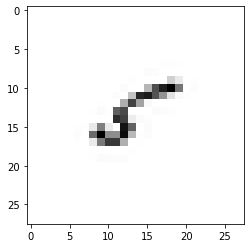

In [0]:
from matplotlib import pyplot as plt

plt.imshow(eg_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

We have the dataset as a tf.data.Dataset, preprocessing can be accomplished using Dataset transformations.

In [0]:
SHUFFLE_BUFFER = 50
# This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, 
# replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
# For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, 
# then shuffle will initially select a random element from only the first 1,000 elements in the buffer. 
# Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

PREFETCH_BUFFER = 50

BATCH_SIZE = 25


def preprocess(dataset):

  def batch_format_fn(element):
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'],[-1,784]),
        y = tf.reshape(element['label'], [-1,1])
    )

  return dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

# Prefetch: This allows later elements to be prepared while the current element is being processed. 
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.


In [0]:
preprocessed_eg_dataset = preprocess(eg_dataset)


In [0]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_eg_dataset)))

# sample_batch

In [0]:
def make_federated_dataset(client_data, client_IDs):
  return [
          preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_IDs
  ]
  

In [0]:
NUM_CLIENTS = 50
# import random  
import random 
# from random import sample 
  
sample_clients = random.sample(emnist_train.client_ids,NUM_CLIENTS)

federated_train_data = make_federated_dataset(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Number of client datasets: 50
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [0]:
# def create_keras_model():
#   return tf.keras.models.Sequential([
#       tf.keras.layers.Input(shape=(784,)),
#       tf.keras.layers.Dense(10, kernel_initializer='zeros'),
#       tf.keras.layers.Softmax(),
#   ])

# def model_fn():
#   keras_model = create_keras_model()
#   return tff.learning.from_keras_model(
#       keras_model,
#       input_spec=preprocessed_eg_dataset.element_spec,
#       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [0]:
# iterative_process = tff.learning.build_federated_averaging_process(
#     model_fn,
#     client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
#     server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.8))

# state = iterative_process.initialize()
# NUM_ROUNDS = 50

# for round_num in range(1, NUM_ROUNDS):
#   state, metrics = iterative_process.next(state, federated_train_data)
#   print('round {:2d}, metrics={}'.format(round_num, metrics))


In [0]:
def create_keras_model():
  temp_model = tf.keras.models.Sequential()
  temp_model.add(tf.keras.layers.Reshape((28, 28,1), input_shape=(784,)))
  temp_model.add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu',
            input_shape=(28,28,1)))
  temp_model.add(tf.keras.layers.MaxPool2D())
  temp_model.add(tf.keras.layers.Conv2D(48,kernel_size=5,padding='same',activation='relu'))
  temp_model.add(tf.keras.layers.MaxPool2D())
  temp_model.add(tf.keras.layers.Flatten())
  temp_model.add(tf.keras.layers.Dense(256, activation='relu'))
  temp_model.add(tf.keras.layers.Dense(10, activation='softmax'))
  # model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  # return tf.keras.models.Sequential([
  #     tf.keras.layers.Input(shape=(784,)),
  #     tf.keras.layers.Dense(10, kernel_initializer='zeros'),
  #     tf.keras.layers.Softmax(),
  # ])
  return temp_model

def model_fn():
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_eg_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

state = iterative_process.initialize()
NUM_ROUNDS = 50


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
import time


In [0]:
for round_num in range(1, NUM_ROUNDS):
  start_time = time.time()
  state, metrics = iterative_process.next(state, federated_train_data)
  end_time = time.time()
  print('round {:2d}, metrics={}'.format(round_num, metrics))
  print('time taken is {:2f}'.format(end_time-start_time))


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<trace.<locals>.async_trace() running at /usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/common_libs/tracing.py:201> wait_for=<Future pending cb=[_chain_future.<locals>._call_check_cancel() at /usr/lib/python3.6/asyncio/futures.py:403, <TaskWakeupMethWrapper object at 0x7f3b3c7d0ca8>()]> cb=[<TaskWakeupMethWrapper object at 0x7f3b46154a98>()]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<trace.<locals>.async_trace() running at /usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/common_libs/tracing.py:201> wait_for=<Future pending cb=[_chain_future.<locals>._call_check_cancel() at /usr/lib/python3.6/asyncio/futures.py:403, <TaskWakeupMethWrapper object at 0x7f3b47c15fd8>()]> cb=[<TaskWakeupMethWrapper object at 0x7f3b46154588>()]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<trace.<locals>.async_trace() running a

round  1, metrics=<sparse_categorical_accuracy=0.15271514654159546,loss=2.3034651279449463>
time taken is 20.362383
round  2, metrics=<sparse_categorical_accuracy=0.1782003492116928,loss=2.2943296432495117>
time taken is 19.826073
round  3, metrics=<sparse_categorical_accuracy=0.23544402420520782,loss=2.28218150138855>
time taken is 20.473526
round  4, metrics=<sparse_categorical_accuracy=0.2448539435863495,loss=2.258678436279297>
time taken is 19.746307
round  5, metrics=<sparse_categorical_accuracy=0.2905312776565552,loss=2.224811315536499>
time taken is 20.480636
round  6, metrics=<sparse_categorical_accuracy=0.3432660400867462,loss=2.1768455505371094>
time taken is 20.885739
round  7, metrics=<sparse_categorical_accuracy=0.38482651114463806,loss=2.1103954315185547>
time taken is 21.092929
round  8, metrics=<sparse_categorical_accuracy=0.3914918601512909,loss=2.0333805084228516>
time taken is 19.575537
round  9, metrics=<sparse_categorical_accuracy=0.46010586619377136,loss=1.9299725

In [0]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
train_metrics = evaluation(state.model, federated_train_data)
print(str(train_metrics))


<sparse_categorical_accuracy=0.890021562576294,loss=0.3539394736289978>


In [0]:
NUM_CLIENTS = 500
  
sample_clients = random.sample(emnist_train.client_ids,NUM_CLIENTS)

federated_test_data = make_federated_dataset(emnist_train, sample_clients)
print("Dataset made")
test_metrics = evaluation(state.model, federated_test_data)
print(str(test_metrics))


/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Dataset made
<sparse_categorical_accuracy=0.8923344612121582,loss=0.35415440797805786>


In [0]:
NUM_CLIENTS = 1500
start_time=time.time()  
sample_clients = random.sample(emnist_train.client_ids,NUM_CLIENTS)
federated_test_data = make_federated_dataset(emnist_train, sample_clients)
print("Dataset made")
end_time=time.time()
print('time taken is {:2f}'.format(end_time-start_time))

start_time=time.time()
test_metrics = evaluation(state.model, federated_test_data)
print(str(test_metrics))
end_time=time.time()
print('time taken is {:2f}'.format(end_time-start_time))


/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Dataset made
time taken is 15.659230
<sparse_categorical_accuracy=0.9007932543754578,loss=0.3310299515724182>
time taken is 287.057438


In [0]:
NUM_CLIENTS = 50
sample_clients = random.sample(emnist_train.client_ids,NUM_CLIENTS)
federated_train_data = make_federated_dataset(emnist_train, sample_clients)


/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [0]:
for round_num in range(1, NUM_ROUNDS):
  start_time = time.time()
  state, metrics = iterative_process.next(state, federated_train_data)
  end_time = time.time()
  print('round {:2d}, metrics={}'.format(round_num, metrics))
  print('time taken is {:2f}'.format(end_time-start_time))


round  1, metrics=<sparse_categorical_accuracy=0.8963065147399902,loss=0.3203691244125366>
time taken is 23.944885
round  2, metrics=<sparse_categorical_accuracy=0.9063796401023865,loss=0.3077973425388336>
time taken is 22.136114
round  3, metrics=<sparse_categorical_accuracy=0.9040094614028931,loss=0.3018355667591095>
time taken is 23.512446
round  4, metrics=<sparse_categorical_accuracy=0.9044045209884644,loss=0.2884303331375122>
time taken is 21.378818
round  5, metrics=<sparse_categorical_accuracy=0.9101323485374451,loss=0.2837064862251282>
time taken is 23.921563
round  6, metrics=<sparse_categorical_accuracy=0.9123049378395081,loss=0.2737898528575897>
time taken is 21.850335
round  7, metrics=<sparse_categorical_accuracy=0.9156626462936401,loss=0.2638072371482849>
time taken is 23.492902
round  8, metrics=<sparse_categorical_accuracy=0.9134899973869324,loss=0.26820266246795654>
time taken is 22.554813
round  9, metrics=<sparse_categorical_accuracy=0.9194153547286987,loss=0.258159

In [0]:
NUM_CLIENTS = 1500
start_time=time.time()  
sample_clients = random.sample(emnist_train.client_ids,NUM_CLIENTS)
federated_test_data = make_federated_dataset(emnist_train, sample_clients)
print("Dataset made")
end_time=time.time()
print('time taken is {:2f}'.format(end_time-start_time))

start_time=time.time()
test_metrics = evaluation(state.model, federated_test_data)
print(str(test_metrics))
end_time=time.time()
print('time taken is {:2f}'.format(end_time-start_time))


/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Dataset made
time taken is 17.764248
<sparse_categorical_accuracy=0.9377539753913879,loss=0.2262464463710785>
time taken is 218.724236
